In [1]:
import torch
import torch_geometric

import networkx as nx
import numpy as np
import scipy
from scipy.io import mmread
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os
import random
import time

from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


## More resources
- https://antoniolonga.github.io/Pytorch_geometric_tutorials/index.html (Very good series)
- http://pages.di.unipi.it/citraro/files/slides/Landolfi_tutorial.pdf


# Data handling

In [2]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, from_networkx

## Data class

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`
- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`
- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

**COO format**
`edge_index` -- COO format (coordinate format) commonly used for representing sparse matrices. Instead of holding the adjacency information in a dense representation $A \in \{0,1\}^{|V|\times|V|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $A$ are **non-zero**.


In [14]:
# ?Data

Let's make the following graph

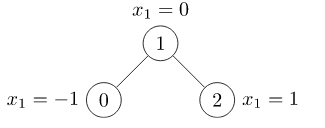

In [15]:
#edges -- both directions
edge_index = torch.tensor([[0, 1, 1, 2],
                          [1, 0, 2, 1]], dtype = torch.long)
print(edge_index)
print(edge_index.shape)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
torch.Size([2, 4])


In [16]:
#node feature map
x = torch.tensor([[-1], [0], [1]], dtype = torch.float)
print(x)
print(x.shape)

tensor([[-1.],
        [ 0.],
        [ 1.]])
torch.Size([3, 1])


In [17]:
data = Data(x = x, edge_index = edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


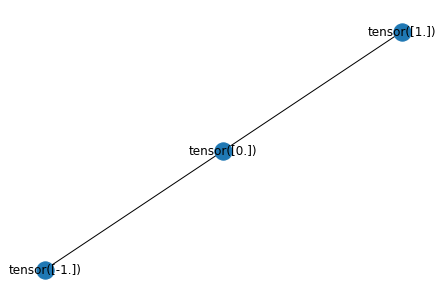

In [18]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels = True, labels = {u: x for u, x in zip(G.nodes, data.x)})

Note that edge_index, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples. If you want to write your indices this way, you should transpose and call contiguous on it before passing them to the data constructor:

In [19]:
edge_index = torch.tensor([[0, 1],
                          [1, 0],
                          [1, 2],
                          [2, 1]], dtype = torch.long
                         )
data = Data(x = x, edge_index = edge_index.t().contiguous())

In [20]:
print('keys: ', data.keys)
print(data['x'])

keys:  ['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])


## Dataset, DataLoader, Batch

In [21]:
#?Dataset
#?DataLoader
#?Batch

In [22]:
edge_index2 = torch.tensor([[0, 1],
                          [1, 0]], dtype = torch.long)
x2 = torch.tensor([[-2], [2]], dtype = torch.float)
data2 = Data(x = x2, edge_index=edge_index2)


In [23]:
dataloader = DataLoader([data, data2], batch_size=2) # Use dataloader like in simple torch

In [24]:
batch = next(iter(dataloader))
print(batch)
print(isinstance(batch, Data)) # Batch is a subclass of Data so the same methods can be used

Batch(x=[5, 1], edge_index=[2, 6], batch=[5], ptr=[3])
True


In [25]:
batch[0], batch[1]

(Data(x=[3, 1], edge_index=[2, 4]), Data(x=[2, 1], edge_index=[2, 2]))

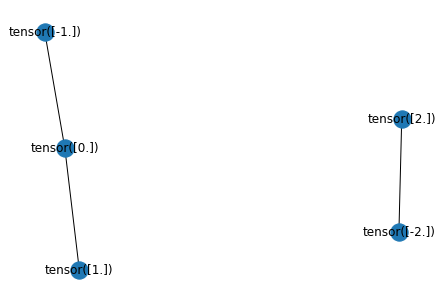

In [26]:
G = to_networkx(batch, to_undirected=True)
nx.draw(G, with_labels = True, labels = {u: x for u, x in zip(G.nodes, batch.x)})

## karate-club

In [5]:
def print_dataset(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')    
    
    
def print_data(data):
    print(data)
    print('=' * 62)

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    if hasattr(data, 'train_mask'):
        print(f'Number of training nodes: {data.train_mask.sum()}')
        print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

In [32]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print_dataset(dataset)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [33]:
data = dataset[0]  # Get the first graph object.
print_data(data)


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


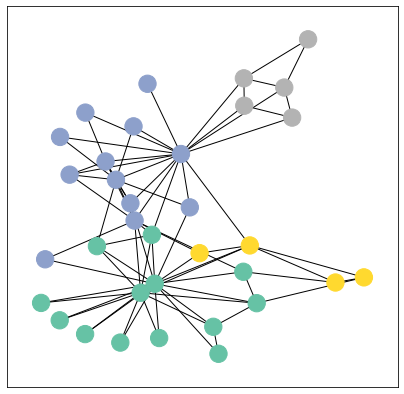

In [34]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize = (7, 7))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                 node_color=data.y, cmap="Set2")
plt.show()

In [35]:
data2 = from_networkx(G)

In [36]:
data2 # Notice we lost the attributes. Inpsect ?to_networkx and ?from_networx to see why

Data(edge_index=[2, 156], num_nodes=34)

## TUDataset

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root = os.path.join('..', 'data', 'tmp', 'ENZYMES'), name = 'ENZYMES')

In [6]:
# Notice that this is a dataset with multiple graphs.

#Inpsect the dataset
print_dataset(dataset)
print()
# Inspect a graph
print_data(dataset[0])

Dataset: ENZYMES(600):
Number of graphs: 600
Number of features: 3
Number of classes: 6

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Number of nodes: 37
Number of edges: 168
Average node degree: 4.54
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


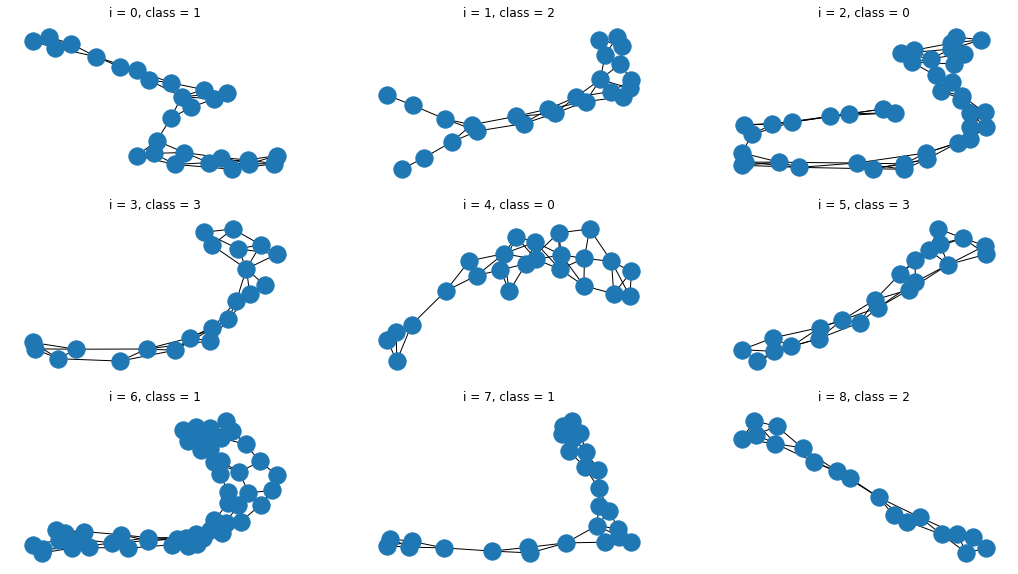

In [9]:
plt.figure(figsize = (18, 10))
for i, data in enumerate(dataset.shuffle()[:9]):
    plt.subplot(3, 3, i+1)
    plt.title(f"{i = }, class = {int(data.y)}")
    G = to_networkx(data, to_undirected=True)
    nx.draw_spring(G)

## Cora dataset

- https://graphsandnetworks.com/the-cora-dataset/

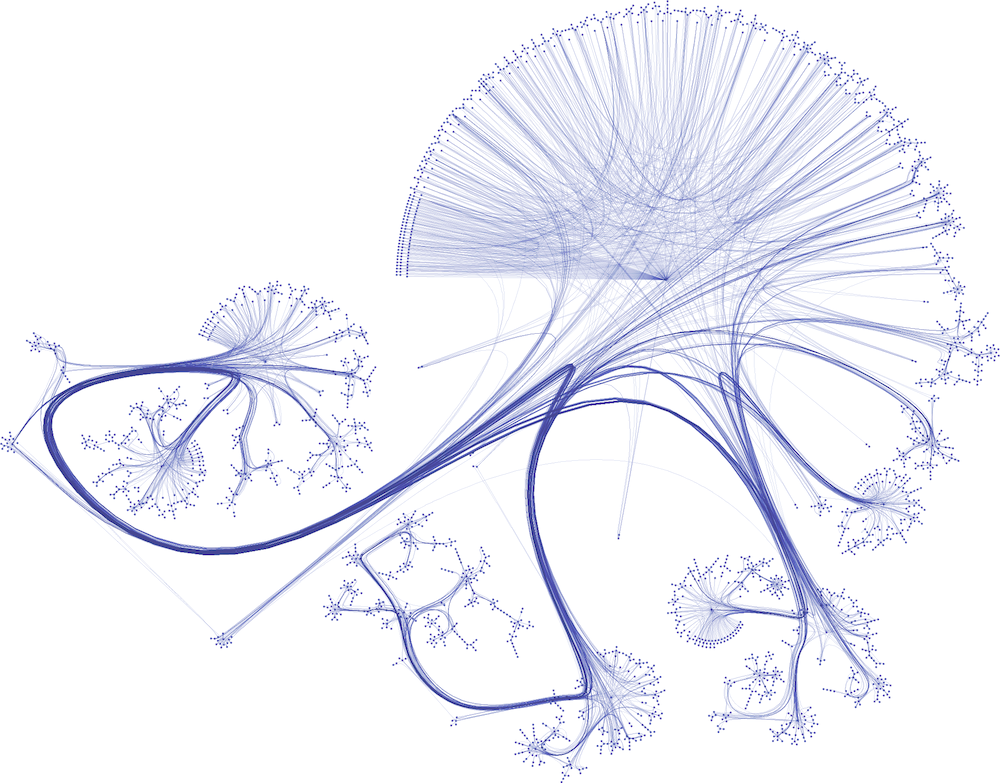

In [40]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')

In [41]:
# This dataset has only 1 graph because it's a datase tfor semi-supervized *graph node classification*
print_dataset(dataset)
print()
print_data(dataset[0])

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [42]:
data = dataset[0]

# The train-val-test split is done with the train_mask, val_mask and test_mask attrs
print(data.train_mask, data.train_mask.sum().item())
print(data.val_mask, data.val_mask.sum().item())
print(data.test_mask, data.test_mask.sum().item())

tensor([ True,  True,  True,  ..., False, False, False]) 140
tensor([False, False, False,  ..., False, False, False]) 500
tensor([False, False, False,  ...,  True,  True,  True]) 1000


# Simple Embeddings

Let's return to our karate graph

In [43]:
dataset = KarateClub()
data = dataset[0]
print_dataset(dataset)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [44]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

Don't worry about the model, will be explained later

In [105]:
import torch
from torch.nn import Linear, Softmax
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # GCN layers
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=hidden_dim)
        self.conv2 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
        # Classifier layer 
        self.classifier = Linear(in_features=hidden_dim, out_features=out_dim) # out_features should be the number of classes
        self.softmax = Softmax(dim = 1) # Transform into probabilities

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)  
        
        # Apply a final (linear) classifier.
        x = self.classifier(h)
        out = self.softmax(x)

        return out, h



In [106]:
model = GCN(input_dim=dataset.num_features, hidden_dim=8, out_dim=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 8)
  (classifier): Linear(in_features=8, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


Embedding shape: [34, 8]


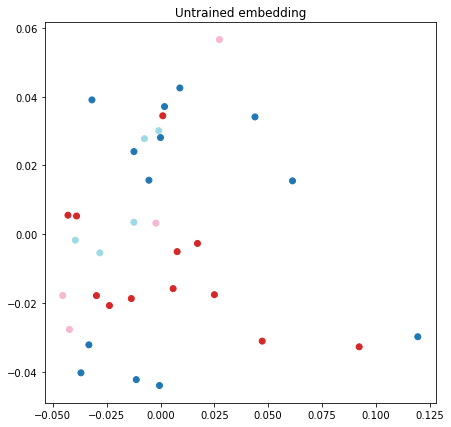

In [107]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
plt.figure(figsize = (7, 7))
plt.title("Untrained embedding")
plt.scatter(*PCA(n_components=2).fit_transform(h.cpu().detach().numpy()).T, c = data.y, cmap = plt.cm.tab20)
#plt.scatter(*h.detach().T, c = data.y, cmap = "Set2", s = 100)
plt.show()

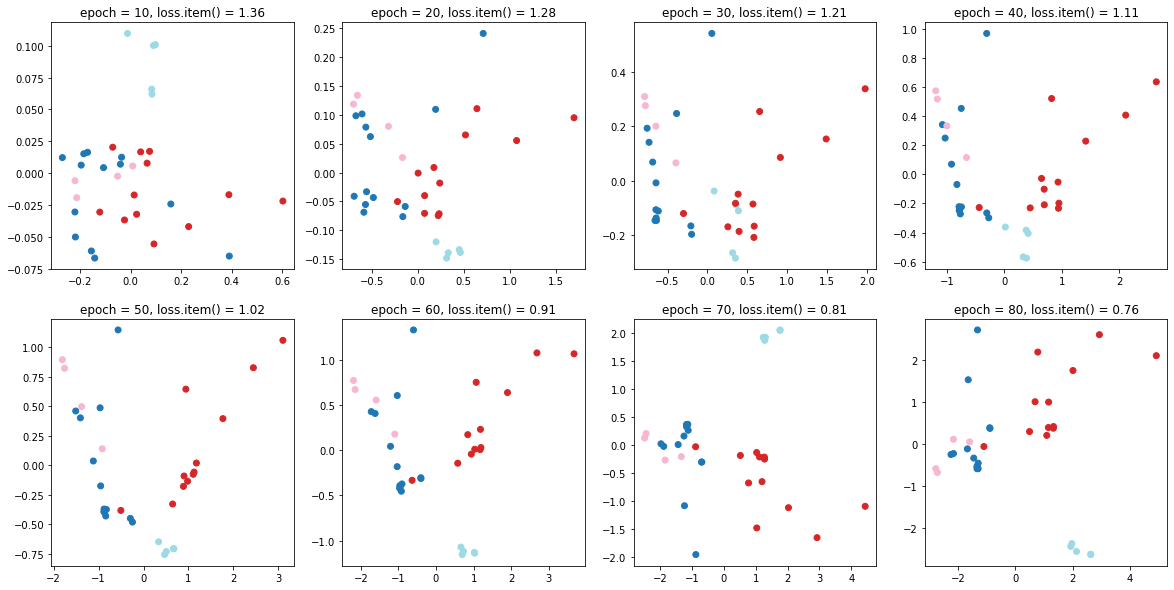

In [109]:
model = GCN(input_dim=dataset.num_features, hidden_dim=8, out_dim=dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h


plt.figure(figsize = (4 * 5, 2 * 5))
for epoch in range(1, 81):
    loss, h = train(data)
    if epoch % 10 == 0:
        plt.subplot(2, 4, epoch // 10)
        plt.title(f"{epoch = }, {loss.item() = :.2f}")
        plt.scatter(*PCA(n_components=2).fit_transform(h.cpu().detach().numpy()).T, c = data.y, cmap = plt.cm.tab20)
plt.show()

In [110]:
out, h = model(data.x, data.edge_index)
out = out.detach().numpy()[~data.train_mask]

In [111]:
accuracy_score(data.y[~data.train_mask], np.argmax(out, axis = 1))

0.7666666666666667